# Tensorflow V2로 학습한 모델을 SageMaker로 배포하기

본 노트북에서는 학습된 모델을 SageMaker endpoint로 배포하는 프로세스를 살펴봅니다. [첫번째 노트북](1.mnist_train.ipynb)에서 매직명령어 %store% 로 저장했던 `model_data`의 모델 아티팩트를 로드하여 사용합니다. (만약 이전에 생성한 모델 아티팩트가 없다면 공개 S3 버킷에서 해당 파일을 다운로드하게 됩니다.)

In [1]:
import sagemaker 
sagemaker.__version__

'2.19.0'

In [1]:
# setups

import os
import json

import sagemaker
from sagemaker.tensorflow import TensorFlowModel
from sagemaker import get_execution_role, Session
import boto3

# Get global config
with open('code/config.json', 'r') as f:
    CONFIG=json.load(f)

sess = Session()
role = get_execution_role()

%store -r tf_mnist_model_data


# store -r 시도 후 모델이 없는 경우 publc s3 bucket에서 다운로드
try: 
    tf_mnist_model_data
except NameError:
    import json
    # copy a pretrained model from a public public to your default bucket
    s3 = boto3.client('s3')
    bucket = CONFIG['public_bucket']
    key = 'datasets/image/MNIST/model/tensorflow-training-2020-11-20-23-57-13-077/model.tar.gz'
    s3.download_file(bucket, key, 'model.tar.gz')
    tf_mnist_model_data = sess.upload_data(
        path='model.tar.gz', bucket=sess.default_bucket(), key_prefix='model/tensorflow')
    os.remove('model.tar.gz')



In [2]:
print(tf_mnist_model_data)

s3://sagemaker-us-east-1-308961792850/tensorflow/mnist/tensorflow-training-2020-12-13-08-24-31-395/model.tar.gz


## TensorFlow Model Object

SageMaker에서 제공하는 `TensorFlowModel` 클래스는 여러분의 모델 아티팩트를 이용하여 추론을 실행하는 환경을 정의하도록 해 줍니다. 이는 [첫번째 노트북](1.mnist_train.ipynb)에서 `TensorFlow` estimator를 정의했던 것과 유사한 방식으로, 학습된 모델을 SageMaker에서 호스팅하도록 도커 이미지를 정의하는 하이레벨 API입니다. 

해당 API를 통해 모델을 추론할 환경을 설정하고 나면 SageMaker에서 관리하는 EC2 인스턴스에서 SageMaker Endpoint 형태로 실행할 수 있습니다. SageMaker Endpoint는 학습된 모델을 RESTful API를 통해 추론하도록 하는 컨테이너기반 환경입니다. 

`TensorFlowModel` 클래스를 초기화할 때 사용되는 파라미터들은 다음과 같습니다.
- role: An IAM role to make AWS service requests
- model_data: the S3 bucket URI of the compressed model artifact. It can be a path to a local file if the endpoint 
is to be deployed on the SageMaker instance you are using to run this notebook (local mode)
- framework_version: version of the MXNet package to be used
- py_version: python version to be used

In [3]:

model = TensorFlowModel(
    role=role,
    model_data=tf_mnist_model_data,
    framework_version='2.3'
)


## 추론 컨테이너 실행

`TensorFlowModel` 클래스가 초기화되고 나면 `deploy`메소드를 이용하여 호스팅용 컨테이너를 실행할 수 있습니다.  

`deploy`메소드 실행시 사용되는 파라미터들은 다음과 같습니다.
- initial_instance_count: 호스팅 서비스에 사용할 SageMaker 인스턴스의 숫자 
- instance_type: 호스팅 서비스를 실행할 SageMaker 인스턴스 타입. 이 값을 `local` 로 선택하면 로컬 인스턴스(SageMaker Jupyter notebook)에 호스팅 컨테이너가 실행됩니다. local mode는 주로 디버깅 단계에서 사용하게 됩니다. 

<span style="color:red"> 주의 : SageMaker Studio 환경에서는 local mode 가 지원되지 않습니다. </span>

In [5]:
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

# set local_mode to False if you want to deploy on a remote
# SageMaker instance

local_mode=False

if local_mode:
    instance_type='local'
else:
    instance_type='ml.c4.xlarge'

predictor = model.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
    )

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-------------!

## SageMaker endpoint를 이용한 예측 실행

`model.deploy(...)`에 의해 리턴된 `Predictor` 인스턴스를 이용하여 예측 요청을 endpoint에 보낼 수 있습니다. In this case, the model accepts normalized batch images in depth-minor convention. 

In [6]:
# use some dummy inputs
import numpy as np

dummy_inputs = {
    'instances': np.random.rand(4, 28, 28, 1)
}

res = predictor.predict(dummy_inputs)
print(res)

{'predictions': [[-0.859399498, -0.730245829, 2.22279906, 2.22489572, -4.3012166, 3.25556207, 0.0117143, -2.04767203, 1.94910419, -0.565921962], [-3.24744844, 0.0327115655, 3.13396335, 3.16278577, -5.01581097, 2.20433211, -1.2074126, -0.146486938, 1.47812605, -1.49816847], [-2.36605787, 0.581350386, 4.27954865, 2.21522665, -4.03555, 2.2487793, -1.32001257, -0.966544569, 1.027156, -1.44832695], [-1.20821476, 0.71104759, 3.54942918, 1.34361947, -2.79953337, 0.96273762, 1.2916081, -0.111170515, 1.64301884, -4.54341888]]}


입출력 데이터 포맷이 [TensorFlow Serving REST API](https://www.tensorflow.org/tfx/serving/api_rest)의 `Predict`에서 정의된 request, respoinst 포맷과 일치하는 지 확인합니다. 

예를 들어 본 코드에서 `dummy_inputs`은 `instances`를 키로 하여 배열의 형태로 전달하고 있습니다. 또한 입력데이터는 batch dimension을 포함한 4차원 배열로 구성되어 있습니다.

In [7]:
# Uncomment the following lines to see an example that cannot be processed by the endpoint

#dummy_data = {
#    'instances': np.random.rand(28, 28, 1).tolist()
#}
#print(predictor.predict(inputs))

이제 실제 MNIST 테스트 데이터로 엔드포인트를 호출해 봅니다. 여기서는 MNIST 데이터를 다운로드하고 normalize하기 위해 `code.utils` 의 헬퍼함수를 사용하였습니다.

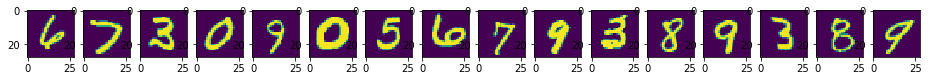

In [8]:
from utils.mnist import mnist_to_numpy, normalize
import random
import matplotlib.pyplot as plt
%matplotlib inline

data_dir = '/tmp/data'
X, _ = mnist_to_numpy(data_dir, train=False)

# randomly sample 16 images to inspect
mask = random.sample(range(X.shape[0]), 16)
samples = X[mask]

# plot the images 
fig, axs = plt.subplots(nrows=1, ncols=16, figsize=(16, 1))

for i, splt in enumerate(axs):
    splt.imshow(samples[i])

모델이 nomalized 된 입력을 받게 되어있으므로 normalize 처리 후 엔디포인트를 호출합니다. 

In [9]:
samples = normalize(samples, axis=(1, 2))
predictions = predictor.predict(
    np.expand_dims(samples, 3) # add channel dim
)['predictions'] 

# softmax to logit
predictions = np.array(predictions, dtype=np.float32)
predictions = np.argmax(predictions, axis=1)


In [10]:
print("Predictions: ", predictions.tolist())

Predictions:  [6, 7, 3, 0, 9, 0, 5, 6, 7, 9, 3, 8, 9, 3, 8, 9]


## (Optional) 리소스 삭제

If you do not plan to use the endpoint, you should delete it to free up some computation 
resource. If you use local, you will need to manually delete the docker container bounded
at port 8080 (the port that listens to the incoming request).


In [11]:
import os

if not local_mode:
    predictor.delete_endpoint()
else:
    os.system("docker container ls | grep 8080 | awk '{print $1}' | xargs docker container rm -f")